## Lectura de los archivos en ruta y construcción de estados, y generación de nuevas tablas

In [ ]:
# se cargan las librerias

import re
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv


#carga las variables de entorno desde archivo .env en carpeta env_variables
%load_ext dotenv
%dotenv ./env_variables/.env


load_dotenv()

# se carga la ruta de los datos
ruta = os.environ['ruta_datos']

# espefición de columnas a rescatar del dataset 
tag1 = 'RIO_20482_CBI_15361_101.SD_CDV_16_NP'
tag2 = 'RIO_20488_CBI_15362_101.SD_CDV_15_BA'

# se identifican las columnas que 
cdv1 = ['frame.number','_ws.col.Time', tag1, tag2]

# crea un dataFrame que tendrá las columnas indicadas; identificación del tren, tiempos y a qué sensor corresponde
result = pd.DataFrame(columns=['numberTrain','timeArriving', 'timeDeparture', 'timeOcuppancy', 'tagCdv'])

# lectura de los archivo .csv desde la ruta y filtra solo estos tipo de archivos .csv
listaFiles= os.listdir(ruta)
for file in listaFiles:
    is_csv = re.search(r'.csv',file, re.IGNORECASE)
    if (is_csv != None):
        df = pd.read_csv(ruta + '/' +  file)

        datos =[]
        
        #filtra las columnas, lo único que se diferencia es que si tiene el tag1 o tag2
        list_columns = [col for col in df.columns if col in cdv1 ]

        # selecciona las columnas del dataFrame
        df_cdv = df[list_columns]

        # muestra los nombres de las columnas, solo por testing.
        print(f'cdv: {df_cdv.columns} , file:{file}')

        # Elimina los valores Nan
        df_cdv = df_cdv.dropna().reset_index(drop=True)
        
        # renombra los nombres de las columnas
        df_cdv = df_cdv.rename(columns={"frame.number": "idx", "_ws.col.Time": "date-time", list_columns[2]:"data"})
        
        #convierte el tipo de dato, desde objet to datatime
        df_cdv['date-time'] = pd.to_datetime(df_cdv['date-time'])
        
        
        #rescata solo el tiempo desde columna date-time
        df_cdv['tiempo'] = df_cdv['date-time'].apply( lambda x: x.time())

        #se filtra los datos entre 6 am to 11 pm
        df_cdv = df_cdv.set_index('date-time').between_time('06:00', '23:00')
        
        # Detecta si el dataFrame está vacio o no, debido a que archivos tienen diferentes ventanas de mediciones
        if(len(df_cdv) > 0):

            
            # detección de cambios de estado de bajo-alto, alto-bajo
            datos = df_cdv

            
            # se convierte la señal
            datos['data'] = abs(datos.data - 1)

            #se inicia primer valor.
            flags = [int(datos.data.iloc[0])]

            # es solo para testing
            #print(f'flags[0]:{flags}')

            # se verifica los estados de máquina
            for x in range(1,len(datos)):
                if (datos.data.iloc[x] == 1 and datos.data.iloc[x-1] == 0):
                    flags.append(1)
                elif(datos.data.iloc[x] == 0 and datos.data.iloc[x-1] == 1):
                    flags.append(2)
                elif(datos.data.iloc[x] == 0 and datos.data.iloc[x-1] == 0):
                    flags.append(0)
                else:
                    flags.append(3)

            # se agrega una columna con los estados = flags
            df_cdv['flags'] = flags
            
            
            # se crean los arreglos de tiempo
            timeArriving = []
            timeDeparture = []
            numberTrain = []
            timeOcuppancy = []

            # se cargan a datos el dataFrame principal
            datos = df_cdv

            # se identifican los cambios de estado 1 y 2 que corresponden a cambios de estado.
            for x in range(len(datos)):
                if(datos['flags'].iloc[x] == 1):
                    timeArriving.append(datos.index[x])
                    numberTrain.append(x)
                elif(datos['flags'].iloc[x] == 2):
                    timeDeparture.append(datos.index[x])

            #diferencia entre listas de datos porque a veces no termina con exactitud en el estado inicial
            diferencia = len(timeDeparture) - len(timeArriving)

            # Elimina el último dato
            if(diferencia < 0):
                timeArriving.pop()
                numberTrain.pop()

            #Calculo de tiempo de ocupacióon
            for y in range(len(timeDeparture)):
                deltaTime = timeDeparture[y] - timeArriving[y]
                timeOcuppancy.append(deltaTime)
            
            # muestra el tamaño de los datos y la diferencia que hubo, solo para testing.
            #print(f'{len(timeArriving)}, {len(timeDeparture)}, {len(timeOcuppancy)}, {len(numberTrain)}, {diferencia}')

            # identifica si el archivo pertenece a tag1 o tag2
            is_cdv1 = tag1 in list_columns
            is_cdv2 = tag2 in list_columns
            
            #Genera columna de tagcdv según el archivo leido
            if (is_cdv1):
                tagCdv = ['cdv1'] * len(timeArriving)
            elif (is_cdv2):
                tagCdv = ['cdv2'] * len(timeArriving)
            else:
                tagCdv = ['None'] * len(timeArriving)

            
            # crea diccionario con las listas creadas para luego crear un dataFrame
            trainDict = {'numberTrain': numberTrain,'timeArriving': timeArriving, 'timeDeparture':timeDeparture, 'timeOcuppancy':timeOcuppancy, 'tagCdv':tagCdv}
            timeDataFrame = pd.DataFrame(trainDict)
            
            #calculo de los minutos
            timeDataFrame['minutes'] = timeDataFrame['timeOcuppancy'] / pd.Timedelta(minutes=1)

            # Une los dataFrame
            frames = [result, timeDataFrame]
            result = pd.concat(frames)

In [2]:
# verificamos que se hayan cargado los datos y columnas.
result.head(5)

,numberTrain,timeArriving,timeDeparture,timeOcuppancy,tagCdv,minutes
0,773,2024-01-02 20:58:21.174256,2024-01-02 20:58:55.581749,0 days 00:00:34.407493,cdv1,0.573458
1,2180,2024-01-02 21:03:02.635136,2024-01-02 21:03:37.042550,0 days 00:00:34.407414,cdv1,0.573457
2,3624,2024-01-02 21:07:51.497472,2024-01-02 21:08:26.104974,0 days 00:00:34.607502,cdv1,0.576792
3,4997,2024-01-02 21:12:26.156647,2024-01-02 21:13:00.564016,0 days 00:00:34.407369,cdv1,0.573456
4,6426,2024-01-02 21:17:12.018821,2024-01-02 21:17:46.426515,0 days 00:00:34.407694,cdv1,0.573462


## Visualización de los datos para saber como se destribuye

In [3]:
# filtra por tag1 y tag 2
data1 = result[result['tagCdv'] == 'cdv1']
data2 = result[result['tagCdv'] == 'cdv2']

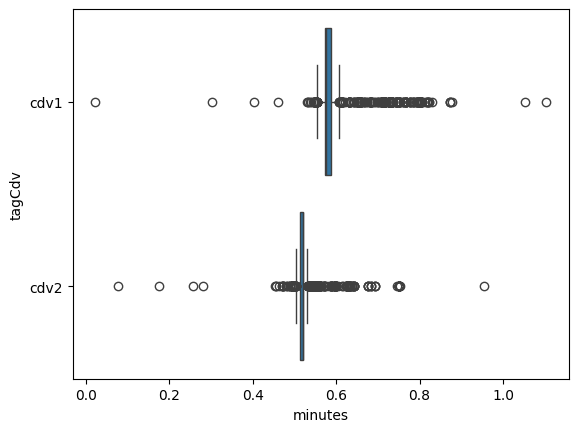

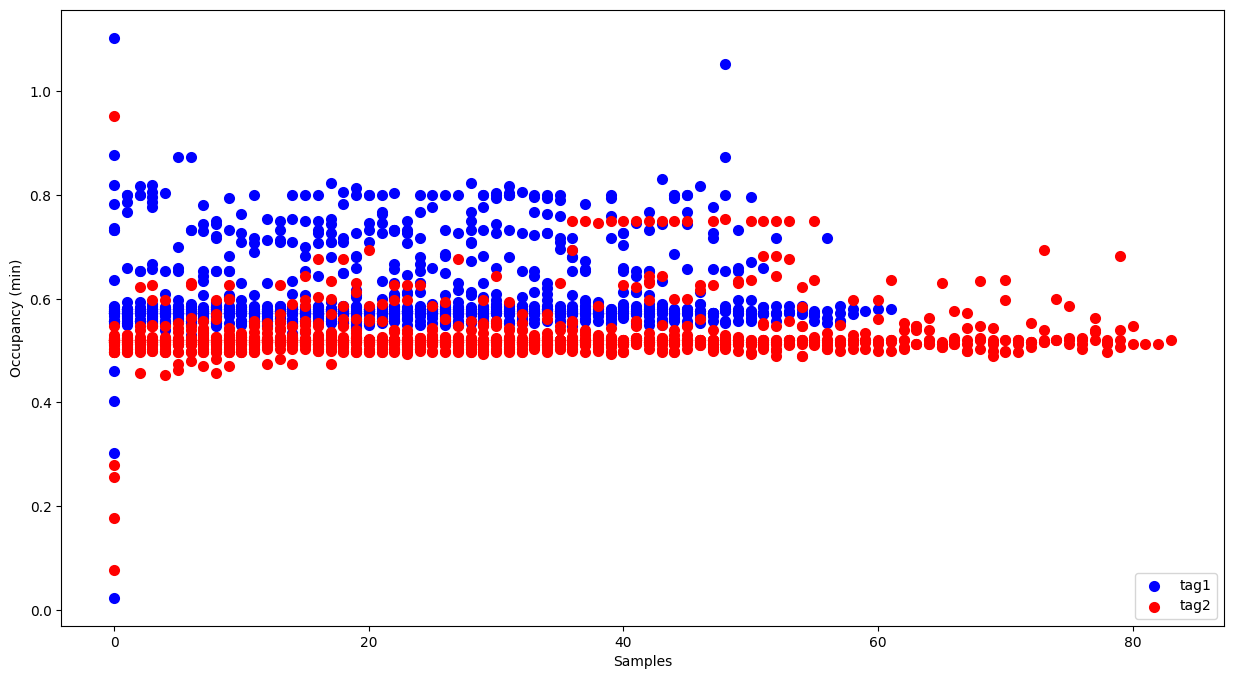

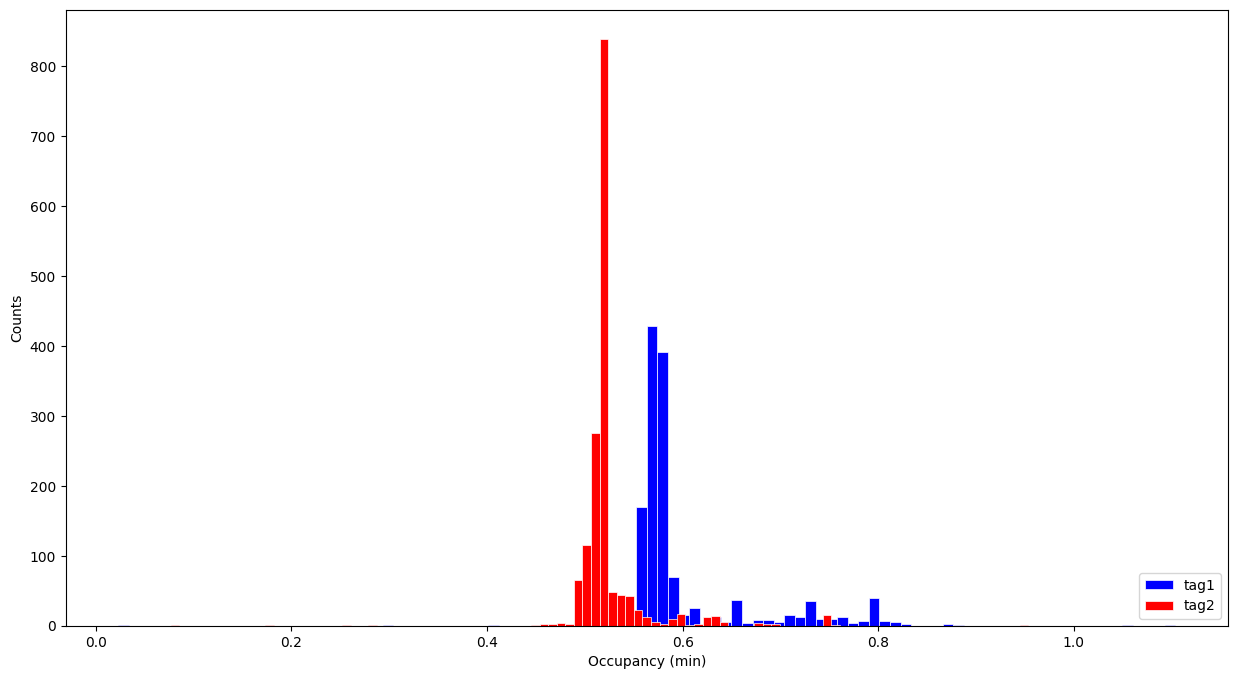

In [10]:
# plot boxplot

data = result

# _1 para tag1 , _2 para tag2
x1, x2 = data1.index, data2.index
y1 , y2 =data1['minutes'], data2['minutes']

# muestra boxplot para tag 1 y tag 2
sns.boxplot(data=result, x="minutes", y="tagCdv")

#-----------------------------------------------------
# grafica los datos 

fig, ax = plt.subplots(figsize=(15,8))

ax.scatter(x1, y1, linewidth=2.0, color='blue')
ax.scatter(x2, y2, linewidth=2.0, color = 'red')
#ax.boxplot(y)

plt.xlabel('Samples') 
plt.ylabel('Occupancy (min)') 
plt.legend(["tag1", "tag2"], loc="lower right")
plt.show

#-----------------------------------------------------
# histograma para tag1

fig, ax = plt.subplots(figsize=(15,8))

ax.hist(y1, bins=100, linewidth=0.5, edgecolor="white", color='blue')
ax.hist(y2, bins=100, linewidth=0.5, edgecolor="white", color='red')
plt.xlabel('Occupancy (min)') 
plt.ylabel('Counts')
plt.legend(["tag1", "tag2"], loc="lower right")
plt.show()

## Diferentes técnicas para encontrar los outliers

detección de outliers usando 1.5*IQR - Para tag1

In [50]:
import numpy as np
# se carga solo datos del tag 1


def calculoCuantil(df,columna):

    # cuantil 0.75 y 0.25
    q75, q25 = np.quantile(df[columna],0.75), np.quantile(df[columna],0.25)

    # quantil interno
    iqr=q75-q25
    corte =1.5*iqr

    #niveles de corte 
    nivel_bajo, nivel_alto = q25-corte, q75+corte

    #almacena los datos en diferentes dataFrame
    df1=df[df['minutes']>nivel_alto]
    df2=df[df['minutes']<nivel_bajo]
    
    #se muestran los niveles min y max
    print(f'valor min: {nivel_bajo} \nvalor max: {nivel_alto}')

    return [nivel_bajo, nivel_alto, df1, df2]



(0.5534331395833334, 0.6068045895833332)

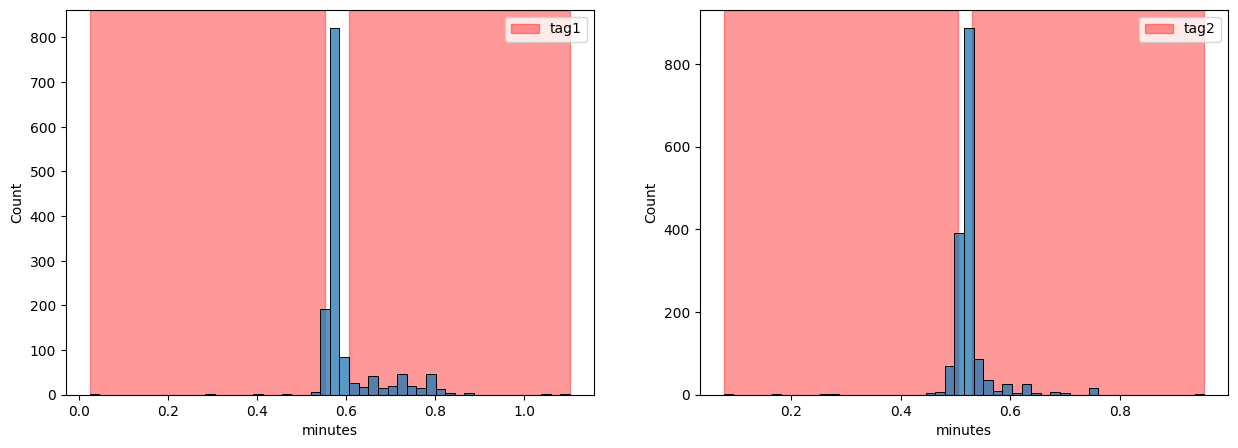

In [98]:
# lista de dataFrames a graficar
lista_datos = [data1, data2]
tags = ['tag1', 'tag2']

subplot_pos = 0
fig, axes = plt.subplots(1, 2, figsize=(15,5))

for ax, datos, xtag in zip(axes, lista_datos, tags):
    niveles_quantles = calculoCuantil(datos,'minutes')
    ax.axvspan(xmin = niveles_quantles[0],xmax= datos.minutes.min(),alpha=0.4, color='red')
    ax.axvspan(xmin = niveles_quantles[1],xmax= datos.minutes.max(),alpha=0.4, color='red')
    sns.histplot(datos.minutes, bins= 50, kde=False, ax=ax)
    ax.legend([xtag], loc="upper right")

<function matplotlib.pyplot.show(close=None, block=None)>

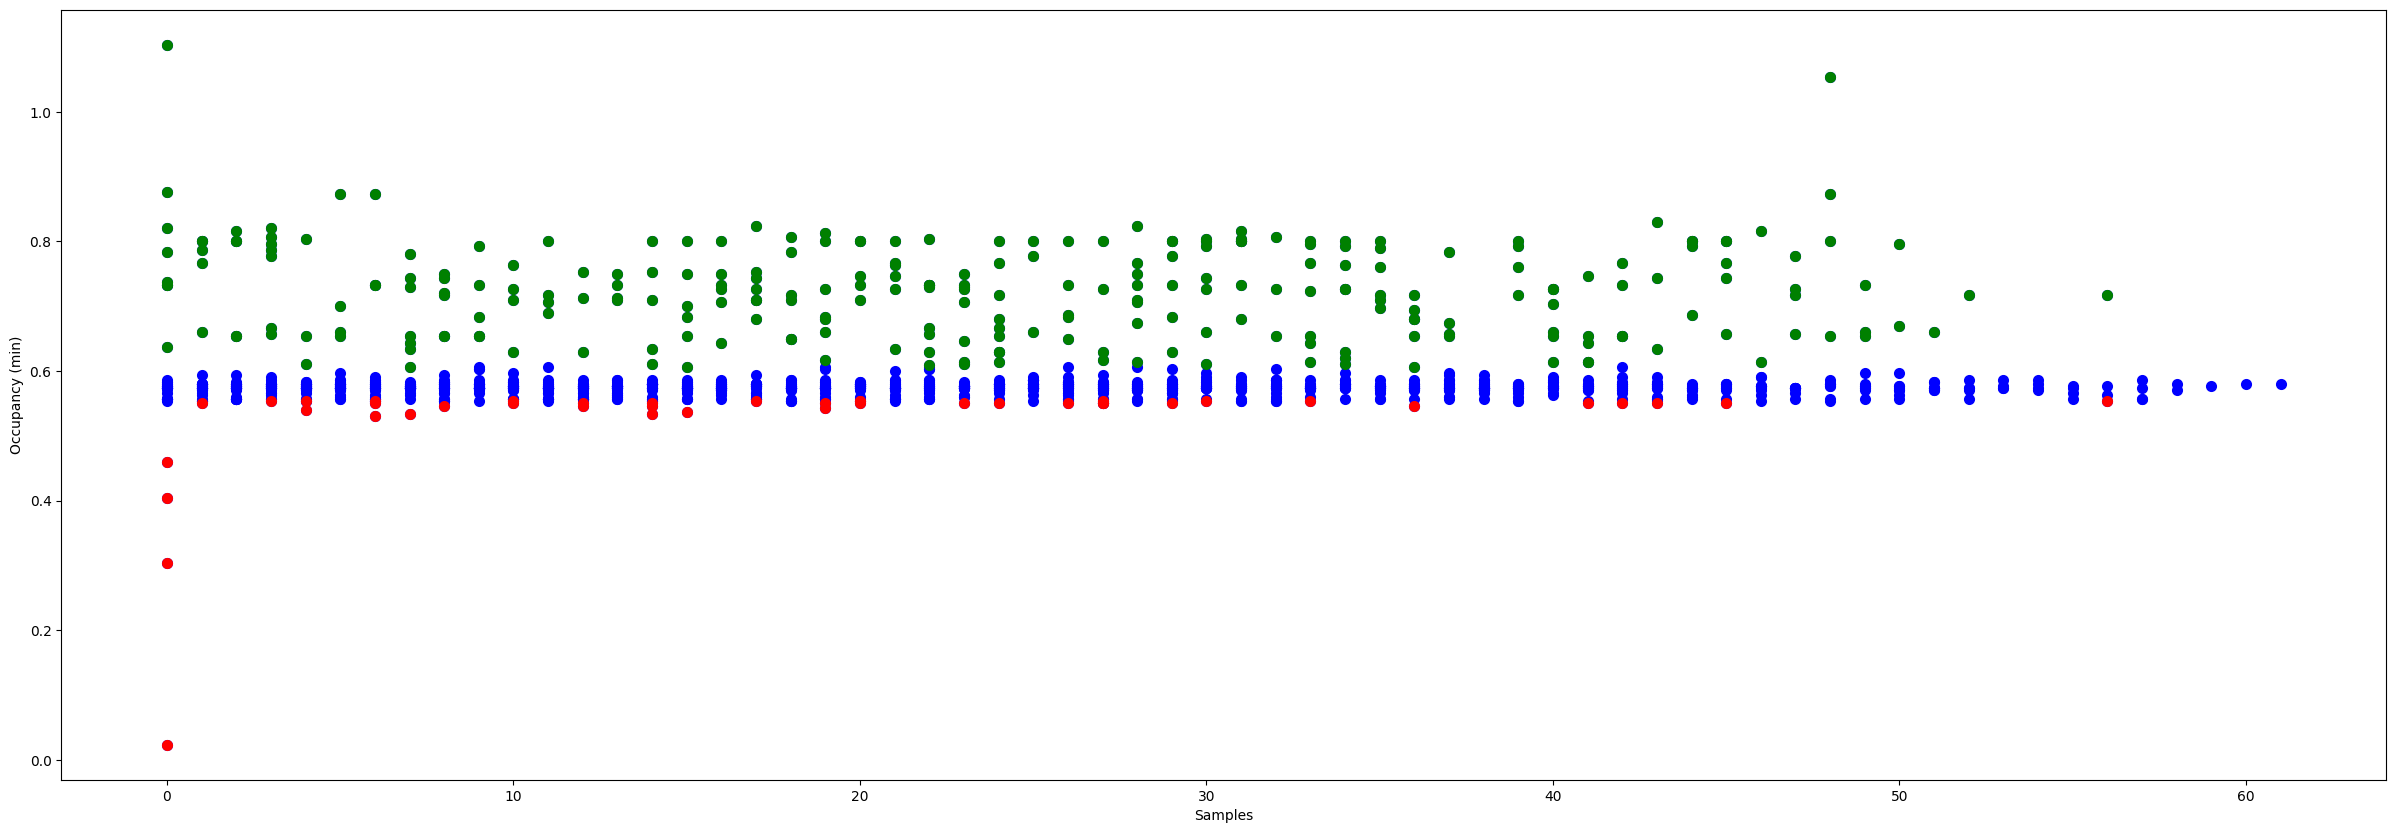

In [47]:
# plot
data = result[result['tagCdv'] == 'cdv1']

#
x1=df1.index
x2=df2.index
x=data.index

#
y=data['minutes']
y1 = df1.minutes
y2 = df2.minutes

#figsize=(30,10)
fig, ax = plt.subplots(figsize=(30,10))
ax.scatter(x, y, linewidth=2.0, color='blue')
ax.scatter(x1, y1, linewidth=2.0, color='green')
ax.scatter(x2, y2, linewidth=2.0, color='red')


plt.xlabel('Samples') 
plt.ylabel('Occupancy (min)') 
plt.show

In [99]:
from sklearn.neighbors import LocalOutlierFactor

df=data1

clf = LocalOutlierFactor( n_neighbors=15, contamination='auto')
X = df[['minutes']].values
y_pred = clf.fit_predict(X)

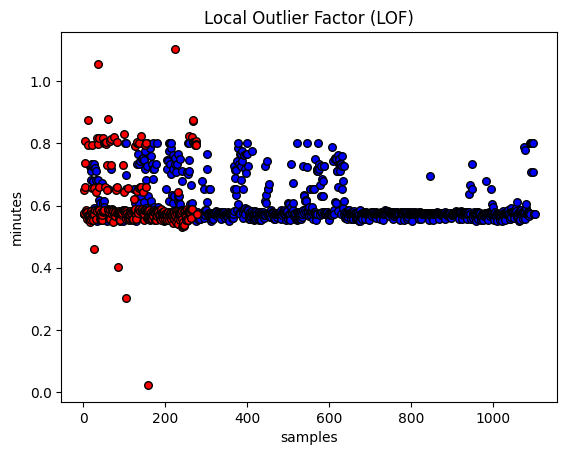

In [101]:
plt.figure()
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

index1 = [item for item in range(1, len(X[in_mask, 0])+1)]
index2 = [item for item in range(1, len(X[out_mask, 0])+1)]

# index1 = [2]*len(X[in_mask, 0])
# index2 = [2]*len(X[out_mask, 0])

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(index1, X[in_mask, 0], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(index2, X[out_mask, 0], c = 'red',
                edgecolor = 'k', s = 30)
plt.xlabel('samples');
plt.ylabel('minutes');
plt.show()

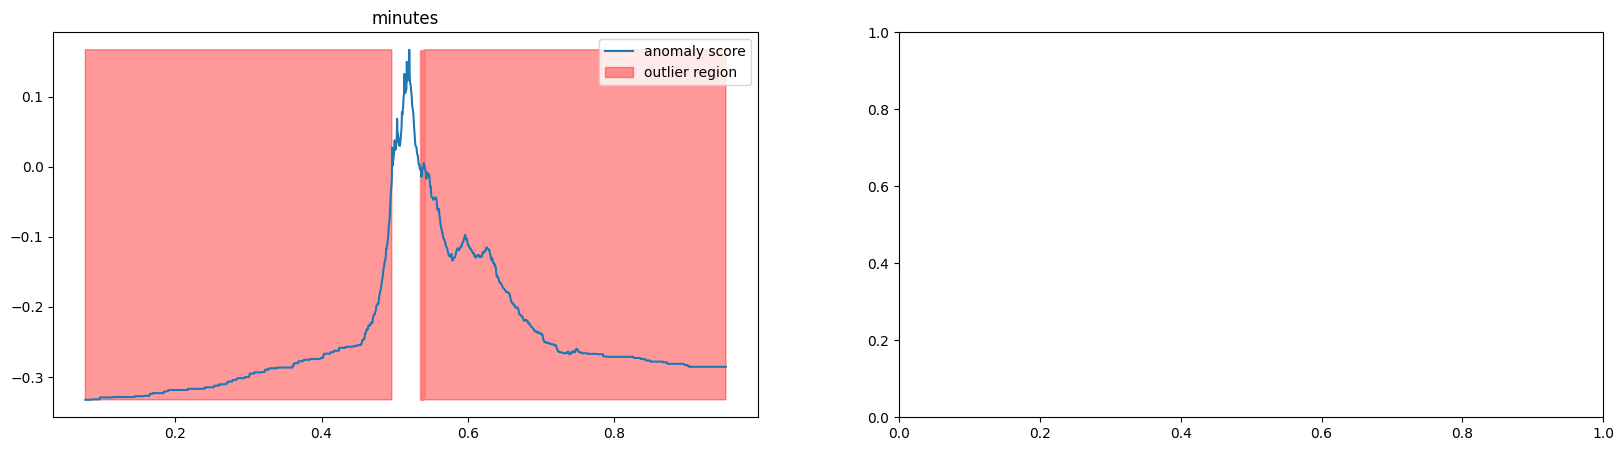

In [122]:
#Import necessary libraries
from sklearn.ensemble import IsolationForest
#The required columns
cols = ['minutes']
#Plotting the sub plot
fig, axs = plt.subplots(1, 2, figsize=(20, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [115]:
from sklearn.cluster import DBSCAN

df =data2
X = df[['minutes']].values

db = DBSCAN(eps=50.0, min_samples=200).fit(X)
labels = db.labels_

In [117]:
pd.Series(labels).value_counts()

0    1581
Name: count, dtype: int64

In [108]:
plt.figure(figsize=(12,12))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Age');
plt.ylabel('BMI');

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 1200x1200 with 0 Axes>

In [ ]:
result[result['tagCdv'] == 'cdv1']